In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting

%matplotlib inline
#%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')
plt.rcParams['axes.grid'] = False

In [2]:
# Function to open the fits file and plot them
def Open_Fits(filepath, plot, cmap='gnuplot2'):
    file_temp = fits.open(filepath)
    file = file_temp[0].data
    file_temp.close()
    if plot == True:
        plt.imshow(file, clim=(0, np.quantile(file, [0.99])), cmap=cmap, origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    return file

# 1) Open Ha and Hb

1.36894385504618e-17

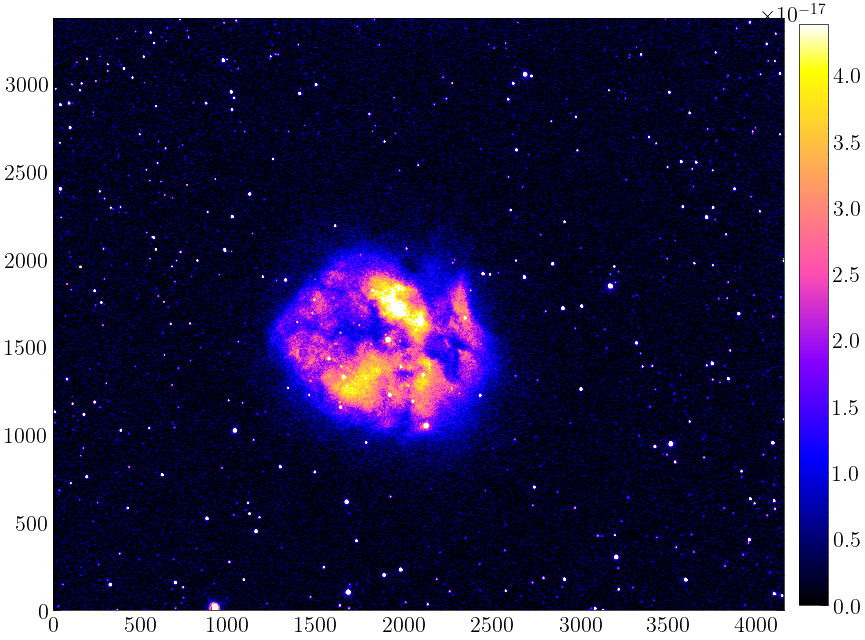

In [3]:
final_Ha_physical = Open_Fits(filepath='Data/final_Ha_physical.fits', plot=True)
final_Ha_physical_err = fits.open('Data/final_Ha_physical.fits')[0].header['error']
final_Ha_physical_err

5.72940128573631e-18

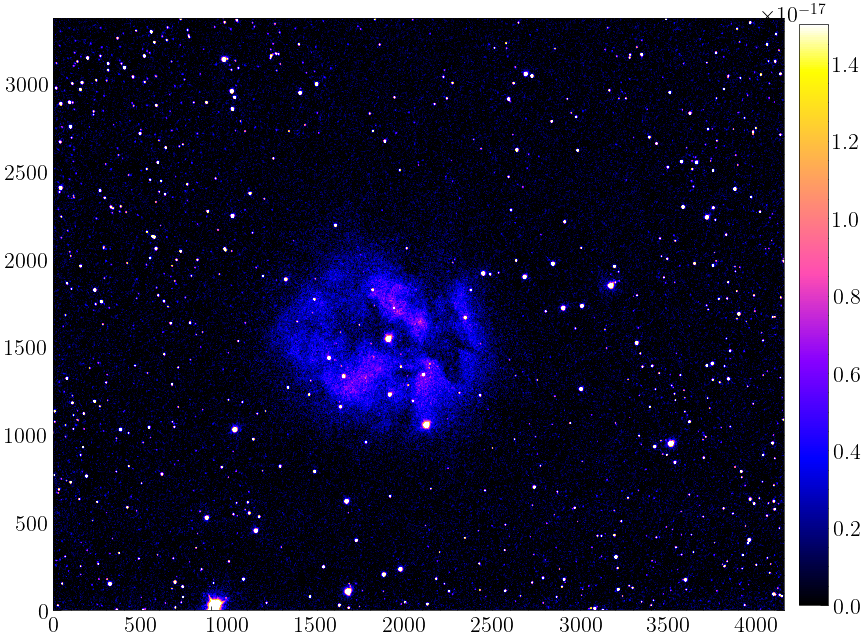

In [4]:
final_Hb_physical = Open_Fits(filepath='Data/final_Hb_physical.fits', plot=True)
final_Hb_physical_err = fits.open('Data/final_Hb_physical.fits')[0].header['error']
final_Hb_physical_err

# 2) Masking the stars

In [5]:
final_Ha_radec = fits.open('Data/final_Ha_radec.fits')[1].data

In [6]:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/355/gaiadr3
# Constraints: 328.25 < RA < 328.5     47.2 < DEC < 47.35     Gmag < 18
GAIA_catalogue = fits.open('Data/GAIA_catalogue_whithin_nebula.fit')[1].data

We are going to perform aperture photometry on 29 stars


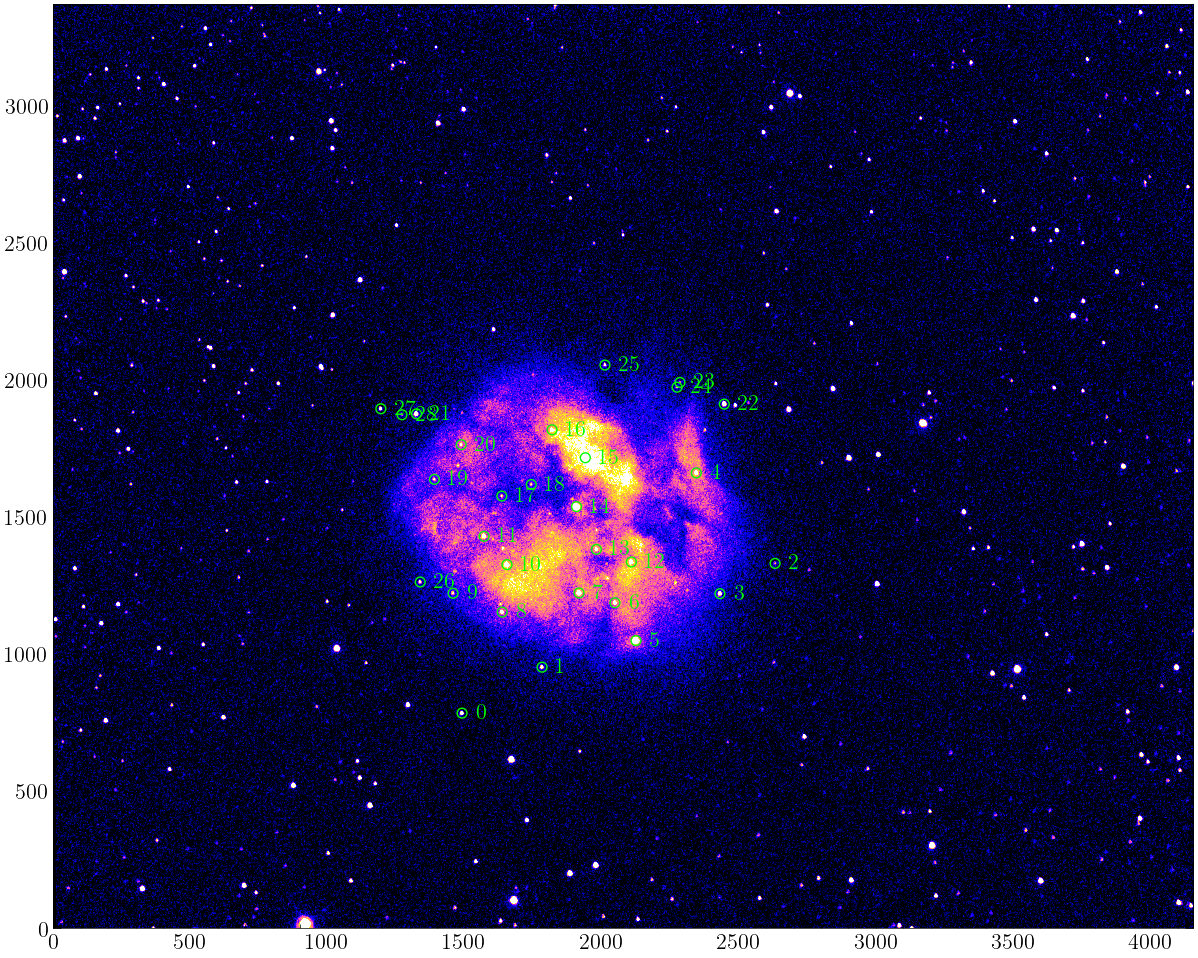

In [7]:
stars_x = []
stars_y = []
stars_Gaianame = []
stars_Gmag = []

for i in range(len(GAIA_catalogue['RA_ICRS'])):
    # Consider only the stars that are bright enough
    if GAIA_catalogue['Gmag'][i] < 15:
        # Find the matches between GAIA stars and our stars
        # If there is only one match, append the coordinates (from astrometry.net) and magnitudes (from GAIA catalogue)
        # If there is no match or more than one match, do nothing
        mask_ra = np.isclose(final_Ha_radec['ra'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.000002)
        mask_dec = np.isclose(final_Ha_radec['dec'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.000002)
        mask_tot = np.logical_and(mask_ra, mask_dec)
        if np.sum(mask_tot) == 1:
            stars_x.append(final_Ha_radec['x'][mask_tot][0])
            stars_y.append(final_Ha_radec['y'][mask_tot][0])
            stars_Gaianame.append(GAIA_catalogue['Source'][i])
            stars_Gmag.append(GAIA_catalogue['Gmag'][i])
        
stars_x = np.array(stars_x)
stars_y = np.array(stars_y)
stars_Gaianame = np.array(stars_Gaianame)
stars_Gmag = np.array(stars_Gmag)
        
plt.figure(figsize=(18,12))
plt.imshow(final_Ha_physical, clim=(0, np.quantile(final_Ha_physical, [0.99])), cmap='gnuplot2', origin='lower')

for i in range(len(stars_x)):
    plt.scatter(stars_x[i], stars_y[i], facecolors='none', edgecolors='lime', s=50)
    plt.text(stars_x[i]+50, stars_y[i]-20, i, c='lime', fontsize=16)
    
print(f'We are going to perform aperture photometry on {len(stars_Gaianame)} stars')

In [8]:
def Mask_Stars(image, stars_x, stars_y, stars_Gaianame, stars_Gmag, plot=False, rectangle_side=40, fwhm_factor=3):
    
    N = len(stars_x)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    mask_stars = image==image
    
    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    
    if plot==True:
        if N % 8 == 0:
            fig_2, axes_2 = plt.subplots(int(N/8), 8, figsize=(24, 4*int(N/8)))
        else:
            fig_2, axes_2 = plt.subplots(int(N/8)+1, 8, figsize=(24, 4*(int(N/8)+1)))


    for i in range(N):
        rectangle_side_i = rectangle_side*(14/stars_Gmag[i])**2
        cutout = image[round(stars_y[i]-rectangle_side_i/2):round(stars_y[i]+rectangle_side_i/2), round(stars_x[i]-rectangle_side_i/2):round(stars_x[i]+rectangle_side_i/2)]

        # 1) Compute the FWHM of the stars to decide the radius of the circular aperture   
        y, x = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
        gaussian_init = models.Gaussian2D(amplitude=np.max(cutout), 
                                          x_mean=cutout.shape[0]/2, 
                                          y_mean=cutout.shape[1]/2, 
                                          x_stddev=cutout.shape[0]/5, 
                                          y_stddev=cutout.shape[1]/5)
        gaussian_fit = fitting.LevMarLSQFitter()
        fitted_gaussian = gaussian_fit(gaussian_init, x, y, cutout)
        mean_x = fitted_gaussian.x_mean.value
        fwhm_x = 2.355*fitted_gaussian.x_stddev.value
        mean_y = fitted_gaussian.y_mean.value
        fwhm_y = 2.355*fitted_gaussian.y_stddev.value
        
            
        # 2) Redefine the centroid and define the aperture radius
        # the cutout frame, in which mean_x and mean_y are defined, is centered on the left-bottom corner of the rectangle
        aperture_centroid = [round(stars_x[i]-rectangle_side_i/2)+mean_x, round(stars_y[i]-rectangle_side_i/2)+mean_y]
        # the aperture radius is a radius, and thus we must divide the FWHM by 2!
        aperture_r = fwhm_factor*np.mean([fwhm_x/2, fwhm_y/2])
        
        
        # 3) Define the circular masks
        dist_from_center = np.sqrt((X - aperture_centroid[0])**2 + (Y-aperture_centroid[1])**2)
        mask_star = dist_from_center <= aperture_r
        mask_stars = np.logical_and(mask_stars, ~mask_star)

        
        # 4) Plot the resulting apertures on the image
        circle_plot = plt.Circle(aperture_centroid, aperture_r, color='lime', linewidth=0.8, fill=False)
        ax.add_patch(circle_plot)
        ax.text(aperture_centroid[0]+1.5*aperture_r, aperture_centroid[1]-0.8*aperture_r, f'{i}', fontsize=15, color='lime')
        
        
        # 5) Plot the cutouts
        if plot==True:
            ax_2 = axes_2.flatten()[i]
            ax_2.set_title(f'Star {i}: {stars_Gaianame[i]} \n ', fontsize=11)
            ax_2.imshow(cutout, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
            circle_plot = plt.Circle([mean_x, mean_y], aperture_r, color='lime', linewidth=1.5, fill=False)
            ax_2.add_patch(circle_plot)
        
            # Remove the unused axes (actually, it does not work)
            for i in range(N % 8):
                axes_2.flatten()[-1-i].axis('off')
    
    return mask_stars

In [9]:
def Mask_Stars(image, stars_x, stars_y, aperture, stars_Gaianame, stars_Gmag, plot=False, rectangle_side=40, fwhm_factor=3):
    
    N = len(stars_x)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    mask_stars = image==image
    
    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    
    if plot==True:
        if N % 8 == 0:
            fig_2, axes_2 = plt.subplots(int(N/8), 8, figsize=(24, 4*int(N/8)))
        else:
            fig_2, axes_2 = plt.subplots(int(N/8)+1, 8, figsize=(24, 4*(int(N/8)+1)))


    for i in range(N):
        rectangle_side_i = rectangle_side*(14/stars_Gmag[i])**2
        cutout = image[round(stars_y[i]-rectangle_side_i/2):round(stars_y[i]+rectangle_side_i/2), round(stars_x[i]-rectangle_side_i/2):round(stars_x[i]+rectangle_side_i/2)]
        
        # 3) Define the circular masks
        dist_from_center = np.sqrt((X - stars_x[i])**2 + (Y-stars_y[i])**2)
        mask_star = dist_from_center <= aperture[i]
        mask_stars = np.logical_and(mask_stars, ~mask_star)

        
        # 4) Plot the resulting apertures on the image
        circle_plot = plt.Circle([stars_x[i], stars_y[i]], aperture[i], color='lime', linewidth=0.8, fill=False)
        ax.add_patch(circle_plot)
        ax.text(stars_x[i]+1.5*aperture[i], stars_y[i]-0.8*aperture[i], f'{i}', fontsize=15, color='lime')
        
        
        # 5) Plot the cutouts
        if plot==True:
            ax_2 = axes_2.flatten()[i]
            ax_2.set_title(f'Star {i}: {stars_Gaianame[i]} \n ', fontsize=11)
            ax_2.imshow(cutout, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
            circle_plot = plt.Circle(np.array(cutout.shape)/2, aperture[i], color='lime', linewidth=1.5, fill=False)
            ax_2.add_patch(circle_plot)
        
            # Remove the unused axes (actually, it does not work)
            for i in range(N % 8):
                axes_2.flatten()[-1-i].axis('off')
    
    return mask_stars

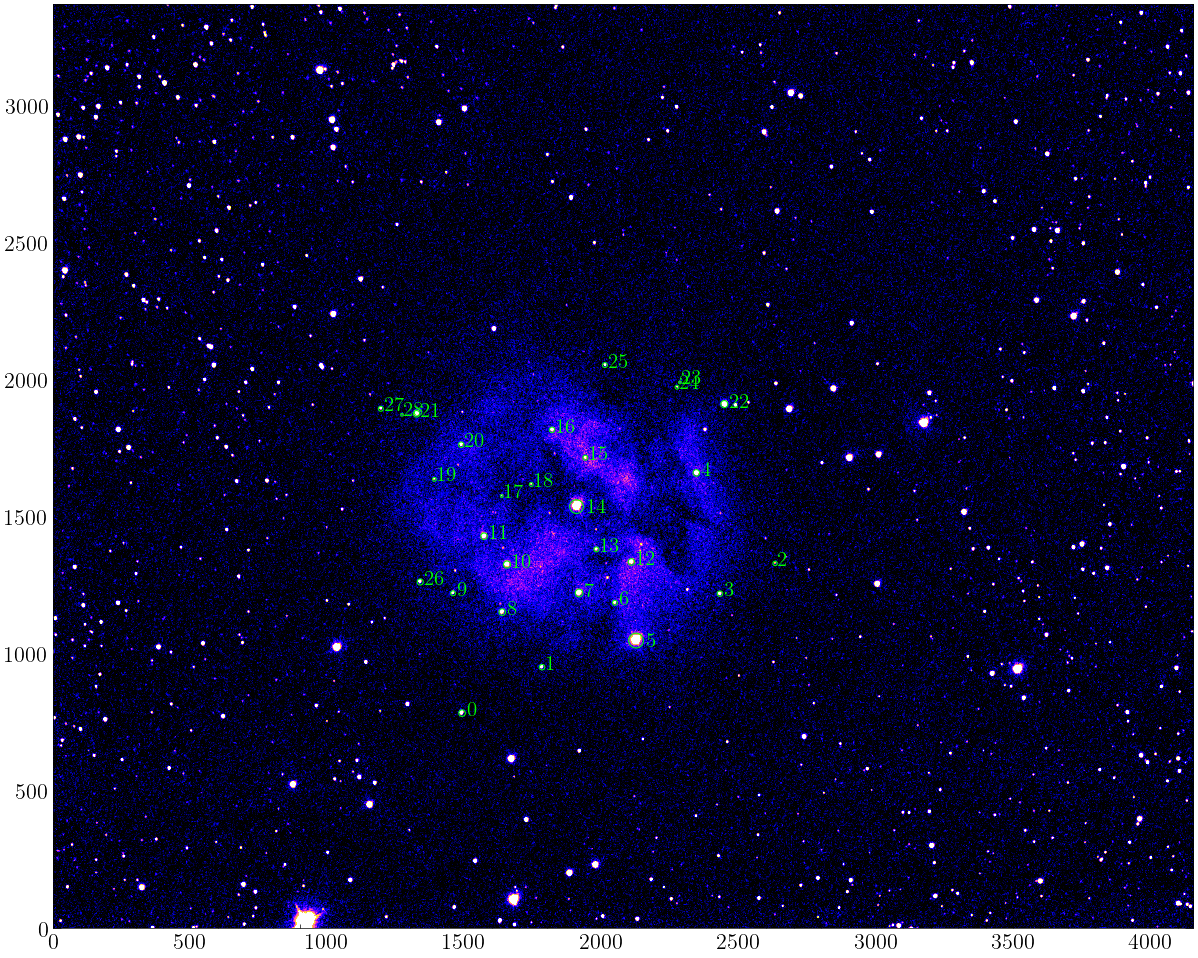

In [10]:
aperture = [12, 10, 8, 10, 12, 27, 9, 14, 12, 9, 13, 12, 12, 9, 25, 9, 10, 5, 7, 7, 10, 12, 13, 5, 7, 9, 11, 9, 5]
mask_stars = Mask_Stars(final_Hb_physical, stars_x, stars_y, aperture, stars_Gaianame, stars_Gmag, plot=False)

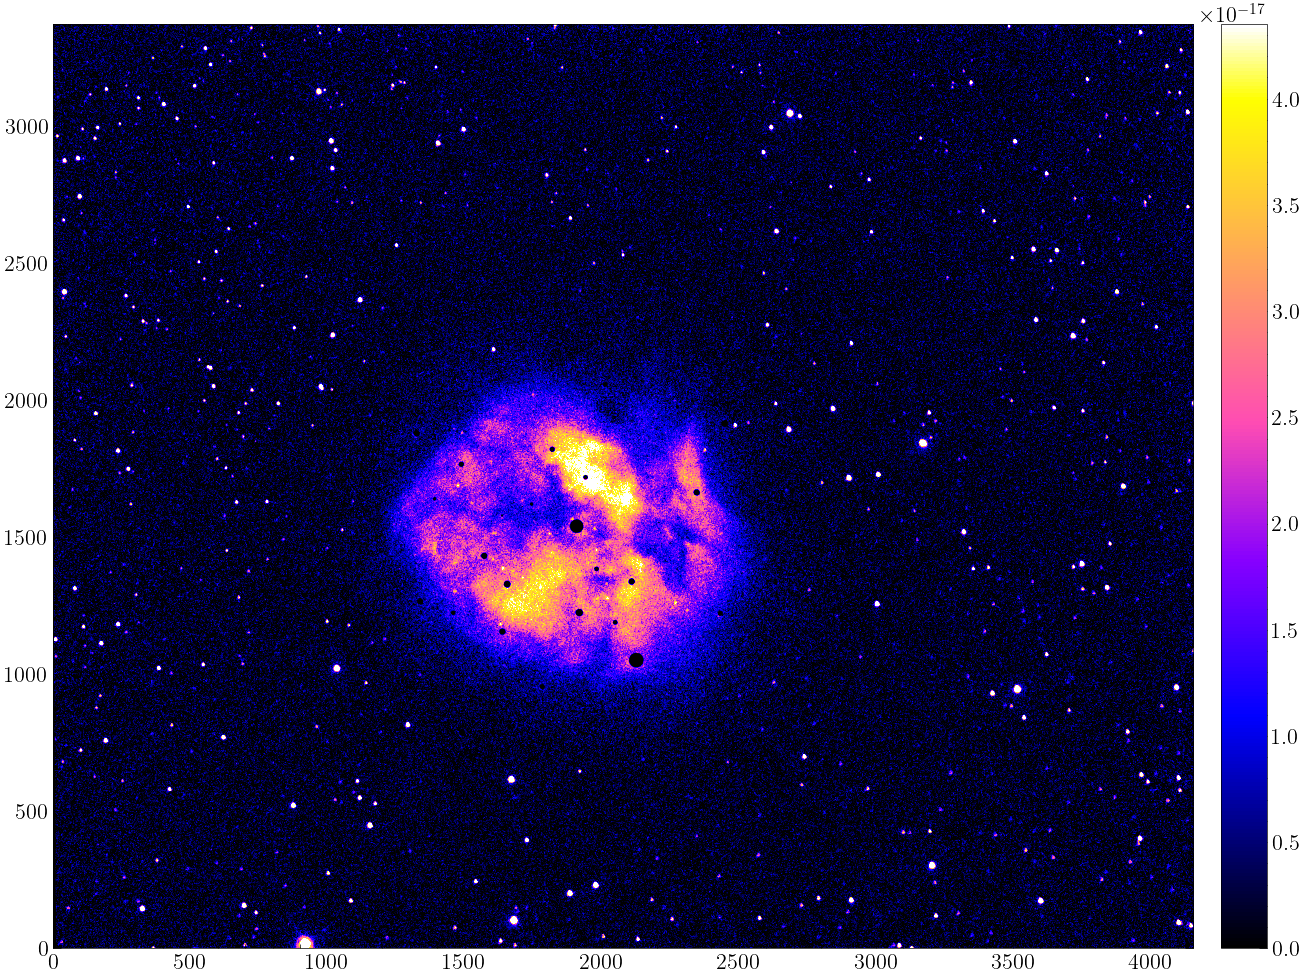

In [11]:
final_Ha_physical_masked = final_Ha_physical.copy()
final_Ha_physical_masked[~mask_stars] = 1e-20

plt.figure(figsize=(18,12))
plt.imshow(final_Ha_physical_masked, clim=(0, np.quantile(final_Ha_physical_masked, [0.99])), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

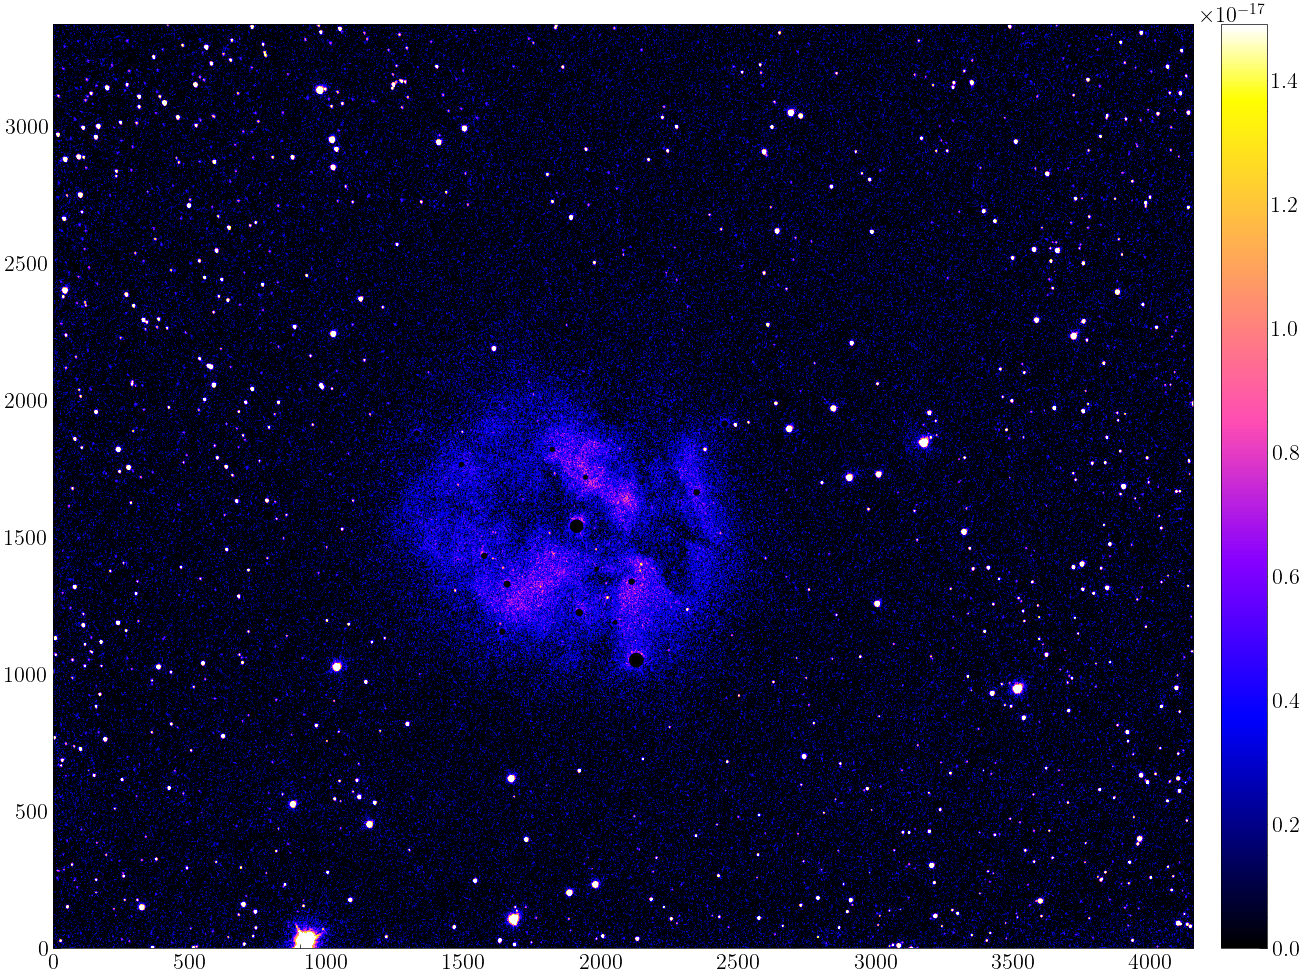

In [12]:
final_Hb_physical_masked = final_Hb_physical.copy()
final_Hb_physical_masked[~mask_stars] = 1e-20

plt.figure(figsize=(18,12))
plt.imshow(final_Hb_physical_masked, clim=(0, np.quantile(final_Hb_physical_masked, [0.99])), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

## Spectrum of the central star

In [13]:
# https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products
#!pip install astroquery
#from astroquery.gaia import Gaia
#
#retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
#data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
#data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
#datalink = Gaia.load_data(ids=stars_Gaianame,
#                          data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure, format='votable', verbose=True, output_file='Spectra/Gaia_spectra', overwrite_output_file='True')
#
#dl_keys  = [inp for inp in datalink.keys()]
#
#print()
#print(f'The following Datalink products have been downloaded:')
#for dl_key in dl_keys:
#    print(f' * {dl_key}')

In [14]:
#wavelengths = datalink[dl_keys[13]][0].to_table().as_array()['wavelength']
#wavelengths = 10*np.ma.getdata(wavelengths)
#
#fluxes = datalink[dl_keys[13]][0].to_table().as_array()['flux']
#fluxes = (10**2)*np.ma.getdata(fluxes)
#
#fluxes_err = datalink[dl_keys[13]][0].to_table().as_array()['flux_error']
#fluxes_err= (10**2)*np.ma.getdata(fluxes_err)
#
#plt.errorbar(wavelengths, fluxes, yerr=fluxes_err, fmt='o', ms=1, color='blue')
#plt.xlabel('Wavelenght $[\AA]$')
#plt.ylabel('Flux $[erg / s / cm^2 / \AA]$');

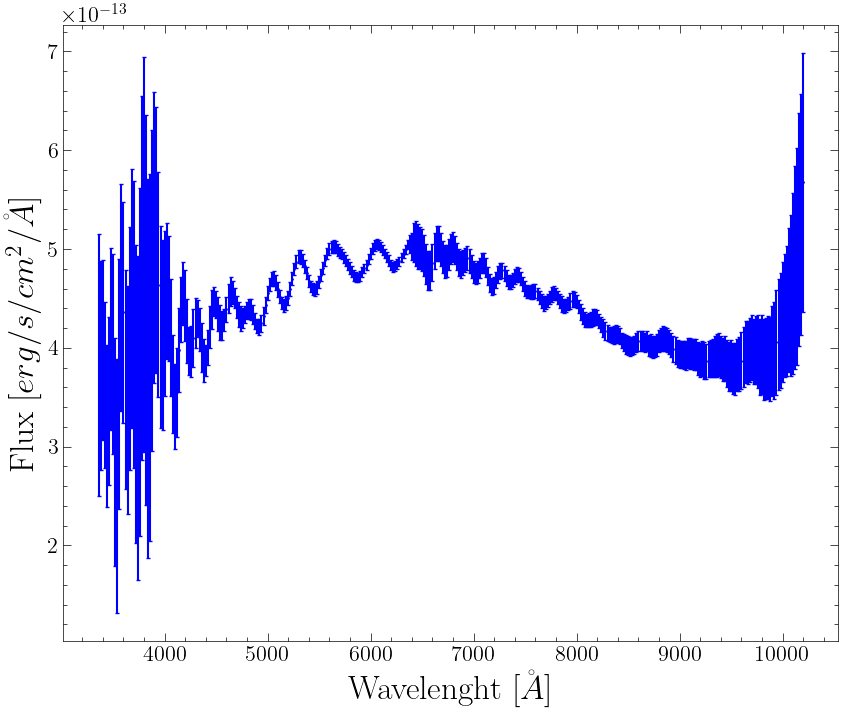

In [15]:
import json

## Save the spectrum of the central star to a dictionary
#data = {"wavelengths": wavelengths.tolist(), 
#        "fluxes": fluxes.tolist(), 
#        "fluxes_err": fluxes_err.tolist()}
#
## Save dictionary to a JSON file
#with open('Data/spectrum_central_star.json', 'w') as f:
#    f.write(json.dumps(data))

# Load the dictionary with the spectrum of the central star from a JSON file
with open('Data/spectrum_central_star.json', 'r') as f:
    data = json.load(f)

wavelengths = np.array(data["wavelengths"])
fluxes = np.array(data["fluxes"])
fluxes_err = np.array(data["fluxes_err"])

plt.errorbar(wavelengths, fluxes, yerr=fluxes_err, fmt='o', ms=1, color='blue')
plt.xlabel('Wavelenght $[\AA]$')
plt.ylabel('Flux $[erg / s / cm^2 / \AA]$');

# 3) Spherical approximation

In [16]:
def Find_Radii(image, center, radius, N_annuli):
    
    # Find an array of radii to have N_annuli concentric annuli of equal area
    radii = []
    radii.append(0)
    TotalArea = np.pi*(radius**2)
    Partition = TotalArea/N_annuli
    for i in range(N_annuli):
        radii.append(np.sqrt(Partition/np.pi + radii[i]**2))
        
    # Plot the annuli
    plt.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    plt.colorbar(fraction=0.0375, pad=0.02)
    for i in range(N_annuli):
        circle = plt.Circle(center, radii[i], color='yellow', fill=False, linewidth=0.5)
        plt.gca().add_artist(circle)
    
    return np.array(radii)

In [17]:
# Function to cover the nebula with a circular mask
def Annulus_Flux(image, image_err, center, r1, r2, mask_stars=None):
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask_int = dist_from_center >= r1
    mask_ext = dist_from_center < r2
    mask_annulus = np.logical_and(mask_int, mask_ext)
    
    flux = np.sum(image[mask_annulus])
    flux_err = np.sqrt(np.sum(image_err**2*np.ones_like(image[mask_annulus])))
    
    if mask_stars is not None:
        mask_tot = np.logical_and(mask_annulus, mask_stars)
        image_temp = image.copy()
        image_temp[~mask_stars] = np.mean(image[mask_tot])
        
        flux = np.sum(image_temp[mask_annulus])
        flux_err = np.sqrt(np.sum(image_err**2*np.ones_like(image_temp[mask_annulus])))
    
    return flux, flux_err

## Filter Ha

array([  0.        ,  75.        , 106.06601718, 129.90381057,
       150.        , 167.70509831, 183.71173071, 198.43134833,
       212.13203436, 225.        , 237.17082451, 248.74685928,
       259.80762114, 270.41634566, 280.62430401, 290.47375097,
       300.        , 309.23292192, 318.19805153, 326.91742077,
       335.41019662, 343.69317712, 351.78118199, 359.68736425,
       367.42346142, 375.        , 382.42646352, 389.7114317 ,
       396.86269666, 403.88736054, 410.79191813, 417.58232721,
       424.26406871, 430.84219849, 437.32139211, 443.70598373,
       450.        , 456.20718977, 462.33105022, 468.37484988,
       474.34164903, 480.23431781, 486.05555238, 491.80788932,
       497.49371855, 503.11529494, 508.67474873, 514.17409503,
       519.61524227, 525.        , 530.33008589, 535.60713214,
       540.83269132, 546.0082417 , 551.13519213, 556.21488653,
       561.24860802, 566.23758265, 571.18298294, 576.08593109,
       580.94750193, 585.76872569, 590.55059055, 595.29

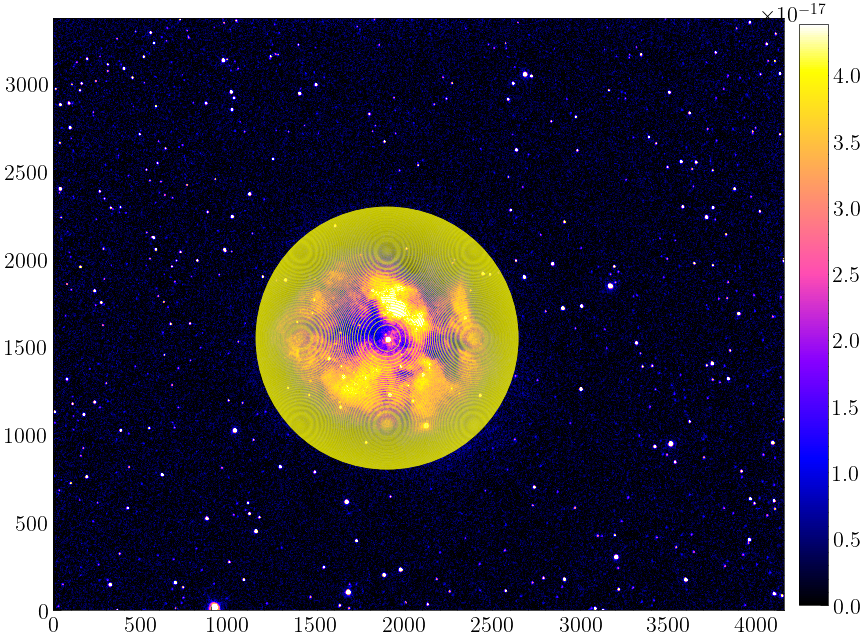

In [18]:
center = [1900, 1550]
radius = 750
N_annuli = 100
 
radii = Find_Radii(final_Ha_physical, center, radius, N_annuli)
radii

In [19]:
annuli_flux = []
annuli_flux_err = []

for i in range(N_annuli):
    annulus_flux, annulus_flux_err = Annulus_Flux(final_Ha_physical, final_Ha_physical_err, center, radii[i], radii[i+1], mask_stars)
    annuli_flux.append(annulus_flux)
    annuli_flux_err.append(annulus_flux_err)
    
annuli_flux = np.array(annuli_flux)
annuli_flux_err = np.array(annuli_flux_err)

https://www.desmos.com/geometry/ywfmmi3btw?lang=it

Referring to the image at the link above:

* $s = 2R \cos(\alpha+\theta) \approx 2R \cos(\theta) \text{  for  } \alpha<<\theta$

* $I(\theta) = \int j ds = j s = 2jR \cos(\theta)$

* $L_\text{annulus} (\theta) = I(\theta) \times S_\text{annulus} \propto \cos(\theta)$

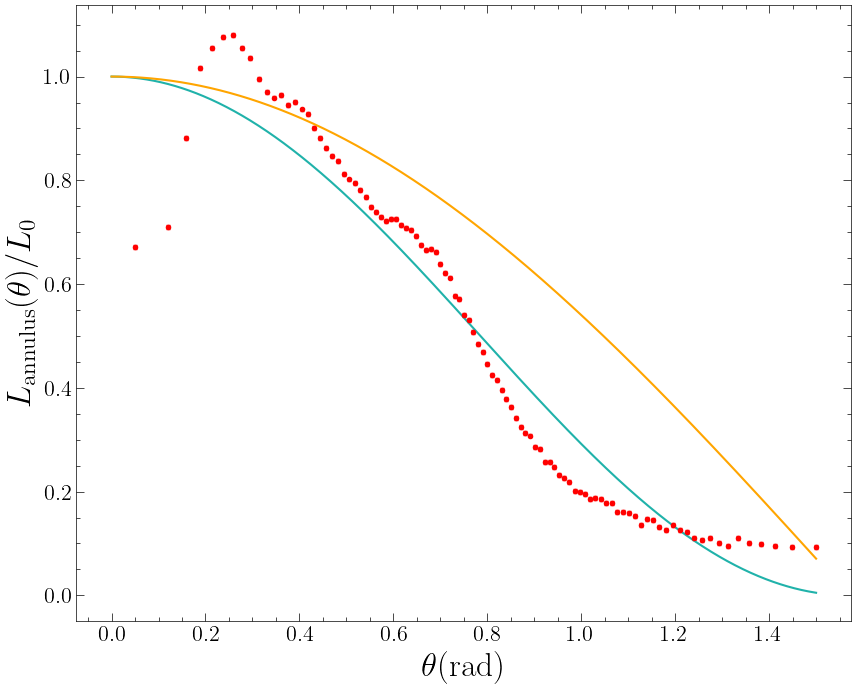

In [20]:
mean_radii = (radii[1:] + radii[:-1])/2
theta = np.arcsin(mean_radii/radius)
C_norm = 0.5/np.mean(annuli_flux)
plt.errorbar(theta, annuli_flux*C_norm, yerr=annuli_flux_err*C_norm, fmt='o', color='red', markersize=3)

theta_dense = np.linspace(0, np.max(theta), 1000)
plt.plot(theta_dense, np.cos(theta_dense)**2, color='lightseagreen')
plt.plot(theta_dense, np.cos(theta_dense), color='orange')
plt.xlabel('$\\theta (\\text{rad})$')
plt.ylabel('$L_\\text{annulus} (\\theta)/L_0$');

## Filter Hb

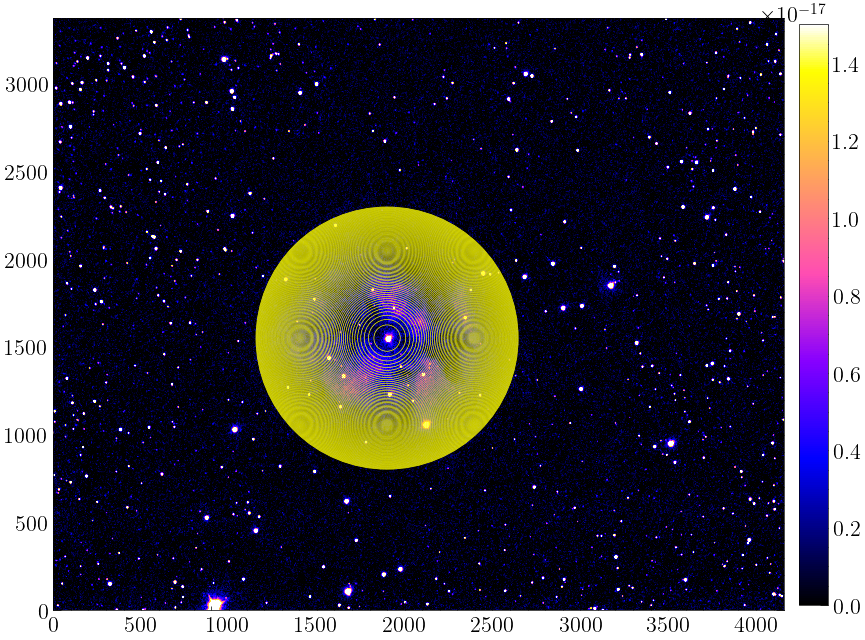

In [21]:
radii = Find_Radii(final_Hb_physical, center, radius, N_annuli)

In [22]:
annuli_flux = []
annuli_flux_err = []

for i in range(N_annuli):
    annulus_flux, annulus_flux_err = Annulus_Flux(final_Hb_physical, final_Hb_physical_err, center, radii[i], radii[i+1], mask_stars)
    annuli_flux.append(annulus_flux)
    annuli_flux_err.append(annulus_flux_err)
    
annuli_flux = np.array(annuli_flux)
annuli_flux_err = np.array(annuli_flux_err)

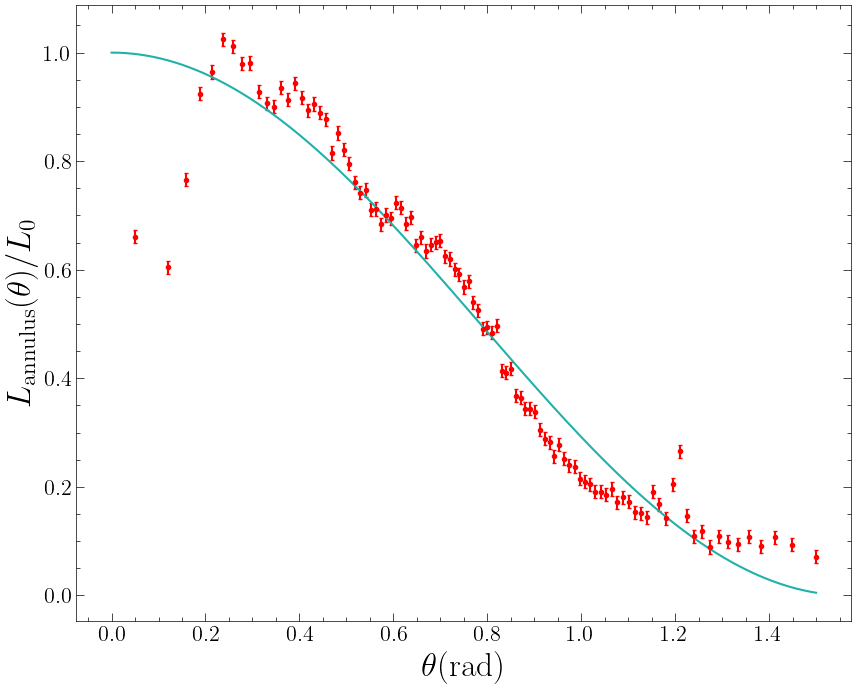

In [23]:
mean_radii = (radii[1:] + radii[:-1])/2
theta = np.arcsin(mean_radii/radius)
C_norm = 0.5/np.mean(annuli_flux)
plt.errorbar(theta, annuli_flux*C_norm, yerr=annuli_flux_err*C_norm, fmt='o', color='red', markersize=3)

theta_dense = np.linspace(0, np.max(theta), 1000)
plt.plot(theta_dense, np.cos(theta_dense)**2, color='lightseagreen')
plt.xlabel('$\\theta (\\text{rad})$')
plt.ylabel('$L_\\text{annulus} (\\theta)/L_0$');